# Visualizing Better Multi-Modal Fused Embeddings of Image and Question Embeddings

In [1]:
import os
import json
from collections import defaultdict, deque

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader


from transformers import AutoImageProcessor, AutoModel
from transformers import BertModel, BertTokenizer

vqa_v2 = {
    'type': 'v2',
    'image_root': 'data/vqa-v2/val2014/val2014/COCO_val2014_000000',
    'questions_path': 'data/vqa-v2/v2_OpenEnded_mscoco_val2014_questions.json',
    'annotations_path': 'data/vqa-v2/v2_mscoco_val2014_annotations.json',
}

vqa_abs = {
    'type': 'abs',
    'image_root': 'data/vqa-abstract/img_train/abstract_v002_train2015_0000000',
    'questions_path': 'data/vqa-abstract/questions_train/OpenEnded_abstract_v002_train2015_questions.json',
    'annotations_path': 'data/vqa-abstract/annotations_train/abstract_v002_train2015_annotations.json',
}

cfg = {
    'n_classes': 25,
    'samples_per_answer': 200,
    'max_q_len': 23,
    'image_encoder': 'facebook/dinov2-base',
    'text_encoder': 'bert-base-uncased',

    'relaxation_period': 3,  # epochs to wait where accuracy is dropping 
                             # below moving average before ending the run
    
    'batch_size': 250,
    'epochs': 100,
    'base_lr': 0.001,

    'fusion_mode': 'cat',
    'num_stacked_attn': 4,

    'weights_save_path': './weights'
}

print('Expected num samples:', cfg['n_classes'] * cfg['samples_per_answer'])

cfg['weights_save_path'] += '/abs_{}-classes_{}-total-samples_{}-lr_{}-stacked_attn-8attn_heads'.format(
    cfg['n_classes'],
    cfg['n_classes'] * cfg['samples_per_answer'],
    cfg['base_lr'],
    cfg['num_stacked_attn']
)

print(cfg['weights_save_path'])

Expected num samples: 5000
./weights/abs_25-classes_5000-total-samples_0.001-lr_1-stacked_attn-8attn_heads


In [2]:
def data_processing(
        dataset, 
        n_classes=cfg['n_classes'], 
        samples_per_answer=cfg['samples_per_answer'],
        train_val_split=0.8):
    """
    Returns 
    1. list of {image_path, question, answer_id}
       -> train_data and val_data
       -> answer_id in the labels list given
       -> len = n_classes * samples_per_answer
    2. list of answer labels
       -> len = n_classes
    """

    with open(dataset['questions_path'], 'r') as file:
        questions = json.load(file)

    with open(dataset['annotations_path'], 'r') as file:
        annotations = json.load(file)

    questions = questions['questions']

    max_q_len = 0
    question_id_map = {}  # question_id : question_text
    for question in questions:
        question_id_map[question['question_id']] = question['question']
        max_q_len = max(max_q_len, len(question['question'].split()))

    print("Max question length = ", max_q_len)

    annotations = annotations['annotations']

    answers = defaultdict(list)  # answer : list of annotation indices
    for annotation in annotations:
        answers[annotation['multiple_choice_answer']] += [(annotation['image_id'], annotation['question_id'])]

    # filtering low occuring examples
    top_answers = deque(maxlen=n_classes)
    top_samples = deque(maxlen=n_classes)

    for answer, sample in answers.items():
        if len(sample) >= samples_per_answer and answer.isdigit() == False:
            top_answers.append(answer)
            top_samples.append(sample[:samples_per_answer])
    
    labels = list(sorted(top_answers))
    print(f'Labels = {labels}')

    train_data = []
    val_data = []
    for answer, samples in zip(top_answers, top_samples):
        for i, sample in enumerate(samples):
            image_id, question_id = sample
            if dataset['type'] == 'v2':
                image_id = str(image_id).zfill(6)
                ext = '.jpg'
            elif dataset['type'] == 'abs':
                image_id = str(image_id).zfill(5)
                ext = '.png'


            image_path = dataset['image_root'] + str(image_id) + ext
            question = question_id_map[question_id]

            data = train_data if i < train_val_split * len(samples) else val_data

            data.append({
                'image_path': image_path,
                'question': question,
                'answer_id': labels.index(answer)
            })

    print(f'Train size = {len(train_data)} | Val size = {len(val_data)} | Total = {len(train_data) + len(val_data)}')

    print('-' * 20)
    return train_data, val_data, labels

In [3]:
class VQADataset(Dataset):
    def __init__(self, data, image_encoder, text_encoder):
        self.data = data

        self.i_processor = AutoImageProcessor.from_pretrained(image_encoder)
        self.q_tokenizer = BertTokenizer.from_pretrained(text_encoder)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data_item = self.data[idx]

        idx_tr = torch.tensor(data_item['answer_id'])
        label = F.one_hot(idx_tr, num_classes=cfg['n_classes']).float()

        image = Image.open(data_item['image_path']).convert('RGB')
        
        i_tokens = self.i_processor(images=image, return_tensors='pt')
        q_tokens = self.q_tokenizer(
            data_item['question'], 
            padding="max_length", 
            max_length=cfg['max_q_len'], 
            truncation=True, 
            return_tensors='pt')

        # dirty way to fix dimention issue:
        i_tokens['pixel_values'] = i_tokens['pixel_values'].squeeze(0)

        for key, value in q_tokens.items():
            q_tokens[key] = value.squeeze(0)

        return i_tokens, q_tokens, label

In [4]:
class VLModel(nn.Module):
    def __init__(
            self, 
            image_encoder, text_encoder, 
            fusion_mode, embed_dim=768,):
        super(VLModel, self).__init__()

        self.fusion_mode = fusion_mode
        self.embed_dim = embed_dim

        self.i_encoder = AutoModel.from_pretrained(image_encoder)
        self.q_encoder = BertModel.from_pretrained(text_encoder)

        num_stacks=cfg['num_stacked_attn']
        output_dim=cfg['n_classes']

        attn_heads = 8
        attn_embed_dim = 768
        
        self.attn_q2i = nn.ModuleList([
            nn.MultiheadAttention(attn_embed_dim, attn_heads, batch_first=True) 
            for _ in range(num_stacks)
        ])

        self.attn_i2q = nn.ModuleList([
            nn.MultiheadAttention(attn_embed_dim, attn_heads, batch_first=True) 
            for _ in range(num_stacks)
        ])
        
        self.attn_i = nn.ModuleList([
            nn.MultiheadAttention(attn_embed_dim, attn_heads, batch_first=True) 
            for _ in range(num_stacks)
        ])

        self.attn_q = nn.ModuleList([
            nn.MultiheadAttention(attn_embed_dim, attn_heads, batch_first=True) 
            for _ in range(num_stacks)
        ])

        if fusion_mode == 'cat': attn_embed_dim *= 2
        self.attn_e = nn.ModuleList([
            nn.MultiheadAttention(attn_embed_dim, attn_heads, batch_first=True) 
            for _ in range(num_stacks)
        ])

        if fusion_mode == 'cat': embed_dim *= 2
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, embed_dim//2),
            nn.ReLU(),
            nn.LayerNorm(embed_dim//2),
            nn.Dropout(),
            nn.Linear(embed_dim//2, embed_dim//4),
            nn.ReLU(),
            nn.LayerNorm(embed_dim//4),
            nn.Dropout(),
            nn.Linear(embed_dim//4, output_dim)
        )

    def cross_attn(self, i, q, attn_q2i, attn_i2q):
        i_attended, _ = attn_q2i(i, q, q)
        q_attended, _ = attn_i2q(q, i, i)

        return i_attended, q_attended
    
    def self_attn_1(self, embedding, attn_e, use_prev=False):
        prev_embedding = embedding
        if not use_prev:
            prev_embedding = torch.zeros((embedding.shape[0], 1, embedding.shape[-1])).cuda()
        
        embedding, _ = attn_e(prev_embedding, embedding, embedding)
        return embedding.squeeze(1)

    def self_attn_2(self, i, q, attn_i, attn_q, use_prev=False):
        prev_i = i
        if not use_prev:
            prev_i = torch.zeros((i.shape[0], 1, self.embed_dim)).cuda()
        i_embeddings, _ = attn_i(prev_i, i, i)

        prev_q = q
        if not use_prev:
            prev_q = torch.zeros((q.shape[0], 1, self.embed_dim)).cuda()
        q_embeddings, _ = attn_q(prev_q, q, q)

        return i_embeddings, q_embeddings

    def forward(self, i_tokens, q_tokens):
        with torch.no_grad():
            i_embeddings = self.i_encoder(**i_tokens).last_hidden_state
            q_embeddings = self.q_encoder(**q_tokens).last_hidden_state

        for stack in range(cfg['num_stacked_attn']):
            # Cross Attention
            i_attended, q_attended = self.cross_attn(
                i_embeddings, q_embeddings, 
                self.attn_q2i[stack], self.attn_i2q[stack])

            # Self Attention
            i_embeddings, q_embeddings = self.self_attn_2(
                i_attended, q_attended, 
                self.attn_i[stack], self.attn_q[stack],
                use_prev = stack > 0)

        # Concat
        if self.fusion_mode == 'cat':
            embedding = torch.cat((i_embeddings, q_embeddings), dim=-1)  # along channels
        elif self.fusion_mode == 'cat_v2':
            i_embeddings = i_embeddings.reshape(i_embeddings.shape[0], -1, self.embed_dim // 2)
            q_embeddings = q_embeddings.reshape(q_embeddings.shape[0], -1, self.embed_dim // 2)
            embedding = torch.cat((i_embeddings, q_embeddings), dim=-1)
        elif self.fusion_mode == 'mult':
            embedding = i_embeddings * q_embeddings
        elif self.fusion_mode == 'add':
            embedding = i_embeddings + q_embeddings

        # Self Attetntion
        for stack in range(cfg['num_stacked_attn']):
            embedding = self.self_attn_1(embedding, self.attn_e[stack], use_prev = stack > 0)

        # FFN
        embedding = self.ffn(embedding)
        
        return embedding

In [5]:
def train(dataloader, model, criterion, optimizer):
    model.train()
    running_loss = 0.0

    for i, (i_tokens, q_tokens, label) in enumerate(dataloader):
        i_tokens = {key: value.cuda() for key, value in i_tokens.items()}
        q_tokens = {key: value.cuda() for key, value in q_tokens.items()}
        label = label.cuda()
        
        logits = model(i_tokens, q_tokens)

        loss = criterion(logits, label)
        running_loss += loss.item()

        if i % (len(dataloader)//4) == 0:
            print(f'\t Iter [{i}/{len(dataloader)}]\t Loss: {loss.item():.6f}')

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_loss = running_loss / len(dataloader)

    return avg_loss


def eval(dataloader, model, criterion):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0

    with torch.no_grad():
        for i_tokens, q_tokens, label in dataloader:
            i_tokens = {key: value.cuda() for key, value in i_tokens.items()}
            q_tokens = {key: value.cuda() for key, value in q_tokens.items()}
            label = label.cuda()
            
            logits = model(i_tokens, q_tokens)

            loss = criterion(logits, label)
            running_loss += loss.item()

            probabilities = torch.sigmoid(logits).squeeze()
            predicted = (probabilities > 0.5).long()
            
            # Compute accuracy
            total += label.shape[0] * label.shape[1]
            correct += (predicted == label).sum().item()

    avg_loss = running_loss / len(dataloader)
    accuracy = (correct / total)
    
    return avg_loss, accuracy

In [6]:
def trainer(dataset):
    train_data, val_data, labels = data_processing(dataset)

    train_dataset = VQADataset(train_data, cfg['image_encoder'], cfg['text_encoder'])
    val_dataset = VQADataset(val_data, cfg['image_encoder'], cfg['text_encoder'])

    train_dataloader = DataLoader(train_dataset, batch_size=cfg['batch_size'], shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=cfg['batch_size'], shuffle=False)

    print('len(train_dataloader) =', len(train_dataloader))

    model = VLModel(cfg['image_encoder'], cfg['text_encoder'], fusion_mode=cfg['fusion_mode']).cuda()

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=cfg['base_lr'])
    scheduler = torch.optim.lr_scheduler.PolynomialLR(optimizer, total_iters=cfg['epochs'], power=0.9)

    train_losses, eval_losses, accuracies = [], [], []
    def plot(epoch):
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))

        ax[0].plot(np.arange(epoch), train_losses, label='Train Loss')
        ax[0].plot(np.arange(epoch), eval_losses, label='Eval Loss')
        ax[0].legend()
        ax[0].set_title('Losses')
        ax[0].set_xlabel('Epoch')
        ax[0].set_ylabel('Loss')

        ax[1].plot(np.arange(epoch), accuracies, label='Accuracy')
        ax[1].legend()
        ax[1].set_title('Accuracy')
        ax[1].set_xlabel('Epoch')
        ax[1].set_ylabel('Accuracy')

        plt.show()

    max_accuracy = 0.0
    low_accuracy_count = 0
    for epoch in range(cfg['epochs']):
        train_loss = train(train_dataloader, model, criterion, optimizer)
        eval_loss, accuracy = eval(val_dataloader, model, criterion)
        scheduler.step()

        train_losses.append(train_loss)
        eval_losses.append(eval_loss)
        accuracies.append(accuracy)

        print(f'Epoch [{epoch+1}/{cfg['epochs']}]\t Avg Train Loss: {train_loss:.6f}\t Avg Eval Loss: {eval_loss:.6f}\t Avg Eval Accuracy: {accuracy:.2f}')

        if epoch > 0 and epoch % (cfg['epochs'] // 8) == 0:
            plot(epoch+1)
        
        if epoch == 0:
            continue

        if accuracies[-1] > max_accuracy:
            max_accuracy = accuracies[-1]
            torch.save(model.state_dict(), cfg['weights_save_path'])
        
        if accuracies[-1] < accuracies[-2]:
            low_accuracy_count += 1
            if low_accuracy_count >= cfg['relaxation_period']:
                plot(epoch+1)
                break
        else:
            low_accuracy_count = 0
    

Max question length =  21
Labels = ['black', 'blue', 'cat', 'couch', 'dog', 'floor', 'food', 'football', 'gray', 'green', 'left', 'nothing', 'plant', 'playing', 'red', 'right', 'rug', 'sitting', 'soccer', 'table', 'watermelon', 'white', 'wine', 'woman', 'yellow']
Train size = 4000 | Val size = 1000 | Total = 5000
--------------------
len(train_dataloader) = 16
	 Iter [0/16]	 Loss: 3.536402
	 Iter [4/16]	 Loss: 3.466710
	 Iter [8/16]	 Loss: 3.216864
	 Iter [12/16]	 Loss: 3.252297
Epoch [1/100]	 Avg Train Loss: 3.338954	 Avg Eval Loss: 3.086700	 Avg Eval Accuracy: 0.39
	 Iter [0/16]	 Loss: 3.178218
	 Iter [4/16]	 Loss: 3.112982
	 Iter [8/16]	 Loss: 3.188724
	 Iter [12/16]	 Loss: 2.938284
Epoch [2/100]	 Avg Train Loss: 3.059950	 Avg Eval Loss: 2.515708	 Avg Eval Accuracy: 0.56
	 Iter [0/16]	 Loss: 2.628297
	 Iter [4/16]	 Loss: 2.579957
	 Iter [8/16]	 Loss: 2.506252
	 Iter [12/16]	 Loss: 2.357477
Epoch [3/100]	 Avg Train Loss: 2.491989	 Avg Eval Loss: 2.159550	 Avg Eval Accuracy: 0.58
	 It

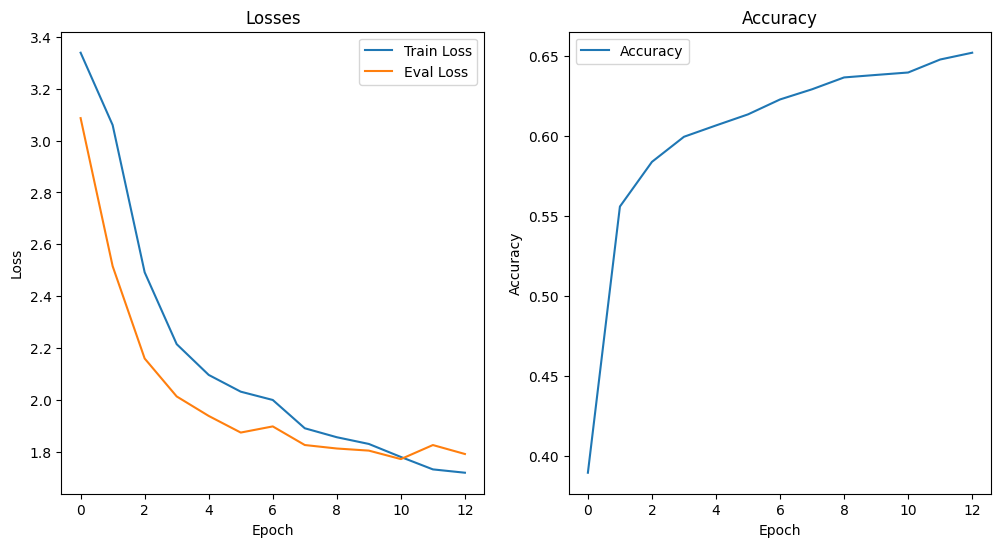

	 Iter [0/16]	 Loss: 1.674128
	 Iter [4/16]	 Loss: 1.875035
	 Iter [8/16]	 Loss: 1.645334
	 Iter [12/16]	 Loss: 1.680738
Epoch [14/100]	 Avg Train Loss: 1.695580	 Avg Eval Loss: 1.733619	 Avg Eval Accuracy: 0.65
	 Iter [0/16]	 Loss: 1.625440
	 Iter [4/16]	 Loss: 1.733779
	 Iter [8/16]	 Loss: 1.547908
	 Iter [12/16]	 Loss: 1.617341
Epoch [15/100]	 Avg Train Loss: 1.599620	 Avg Eval Loss: 1.629308	 Avg Eval Accuracy: 0.65
	 Iter [0/16]	 Loss: 1.495025
	 Iter [4/16]	 Loss: 1.532217
	 Iter [8/16]	 Loss: 1.535623
	 Iter [12/16]	 Loss: 1.529703
Epoch [16/100]	 Avg Train Loss: 1.507128	 Avg Eval Loss: 1.563557	 Avg Eval Accuracy: 0.65
	 Iter [0/16]	 Loss: 1.417681
	 Iter [4/16]	 Loss: 1.429029
	 Iter [8/16]	 Loss: 1.368416
	 Iter [12/16]	 Loss: 1.310455
Epoch [17/100]	 Avg Train Loss: 1.392918	 Avg Eval Loss: 1.459530	 Avg Eval Accuracy: 0.66
	 Iter [0/16]	 Loss: 1.204669
	 Iter [4/16]	 Loss: 1.387219
	 Iter [8/16]	 Loss: 1.290858
	 Iter [12/16]	 Loss: 1.398103
Epoch [18/100]	 Avg Train Loss:

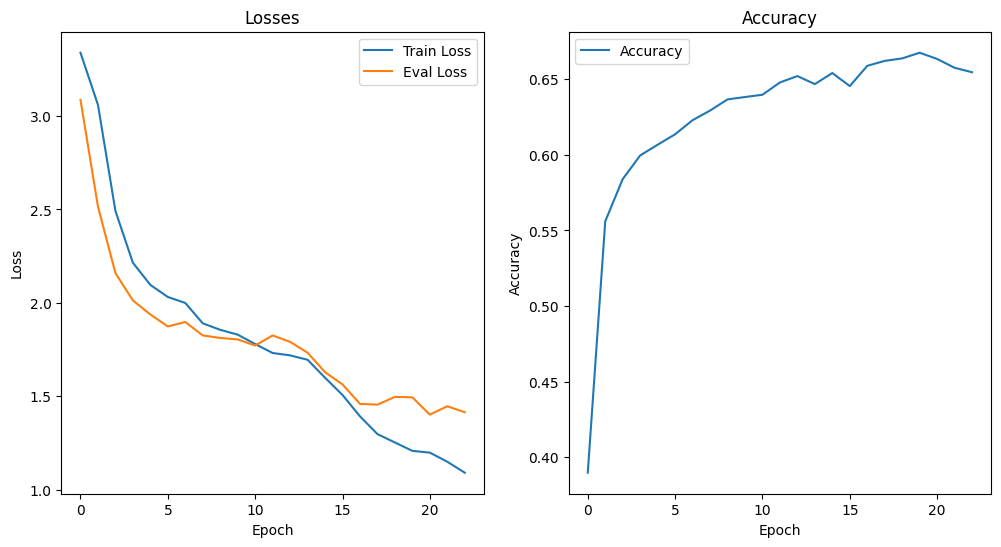

In [7]:
if __name__ == '__main__':
    trainer(dataset=vqa_abs)